In [158]:
import pandas as pd
train = pd.read_csv('house.csv')
test = pd.read_csv('house.test.csv')
train.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


In [163]:
from sklearn.feature_selection import mutual_info_regression
def mutal_info(X, Y, discrete_features):
    info = mutual_info_regression(X, Y, discrete_features=discrete_features)
    info = pd.Series(info, name='mutual_info', index = X.columns)
    info = info.sort_values(ascending=False)
    return info

In [164]:
features = train.columns.drop('Id')
train_X = train[features.drop('SalePrice')]
train_Y = train.SalePrice

In [165]:
numerical_cols = [i for i in train_X.columns if train_X[i].dtype in ['int64', 'float64']]
categorical_cols = [i for i in train_X.columns if train_X[i].nunique() < 20 and train_X[i].dtype == 'object']
my_cols = numerical_cols+categorical_cols
from sklearn.impute import SimpleImputer
X = train[my_cols]
imp = SimpleImputer(strategy='most_frequent')
X = imp.fit_transform(X)
X = pd.DataFrame(X, columns=my_cols)
Y = train.SalePrice
for i in X.select_dtypes('object'):
    X[i], _ = X[i].factorize()
discrete_features = X.dtypes == int

In [185]:
mi_scores = mutal_info(X, Y, discrete_features)
weak_features = mi_scores[mi_scores<0.1].index.tolist()
numerical_cols = [i for i in numerical_cols if i not in weak_features]
categorical_cols = [i for i in categorical_cols if i not in weak_features]
my_cols = numerical_cols + categorical_cols
mi_scores[::3]

OverallQual     5.660098e-01
YearBuilt       4.090835e-01
GarageCars      3.641197e-01
BsmtQual        3.136247e-01
MSSubClass      2.803916e-01
GarageFinish    2.467991e-01
LotFrontage     1.980146e-01
2ndFlrSF        1.687247e-01
BsmtFinSF1      1.496926e-01
BsmtUnfSF       1.247883e-01
OverallCond     1.170797e-01
LotShape        9.233910e-02
SaleType        8.365496e-02
CentralAir      6.961995e-02
MasVnrType      5.592170e-02
BldgType        3.926894e-02
BsmtCond        2.763917e-02
KitchenAbvGr    2.126604e-02
ExterCond       1.613072e-02
LotConfig       1.479277e-02
BsmtHalfBath    9.676967e-03
RoofMatl        5.849975e-03
LandSlope       2.520298e-03
YrSold          1.041522e-03
Utilities       1.887379e-15
MoSold          0.000000e+00
Name: mutual_info, dtype: float64

In [186]:
import matplotlib.pyplot as plt
import numpy as np
def mi_plot(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title('Mutal Information Scores')

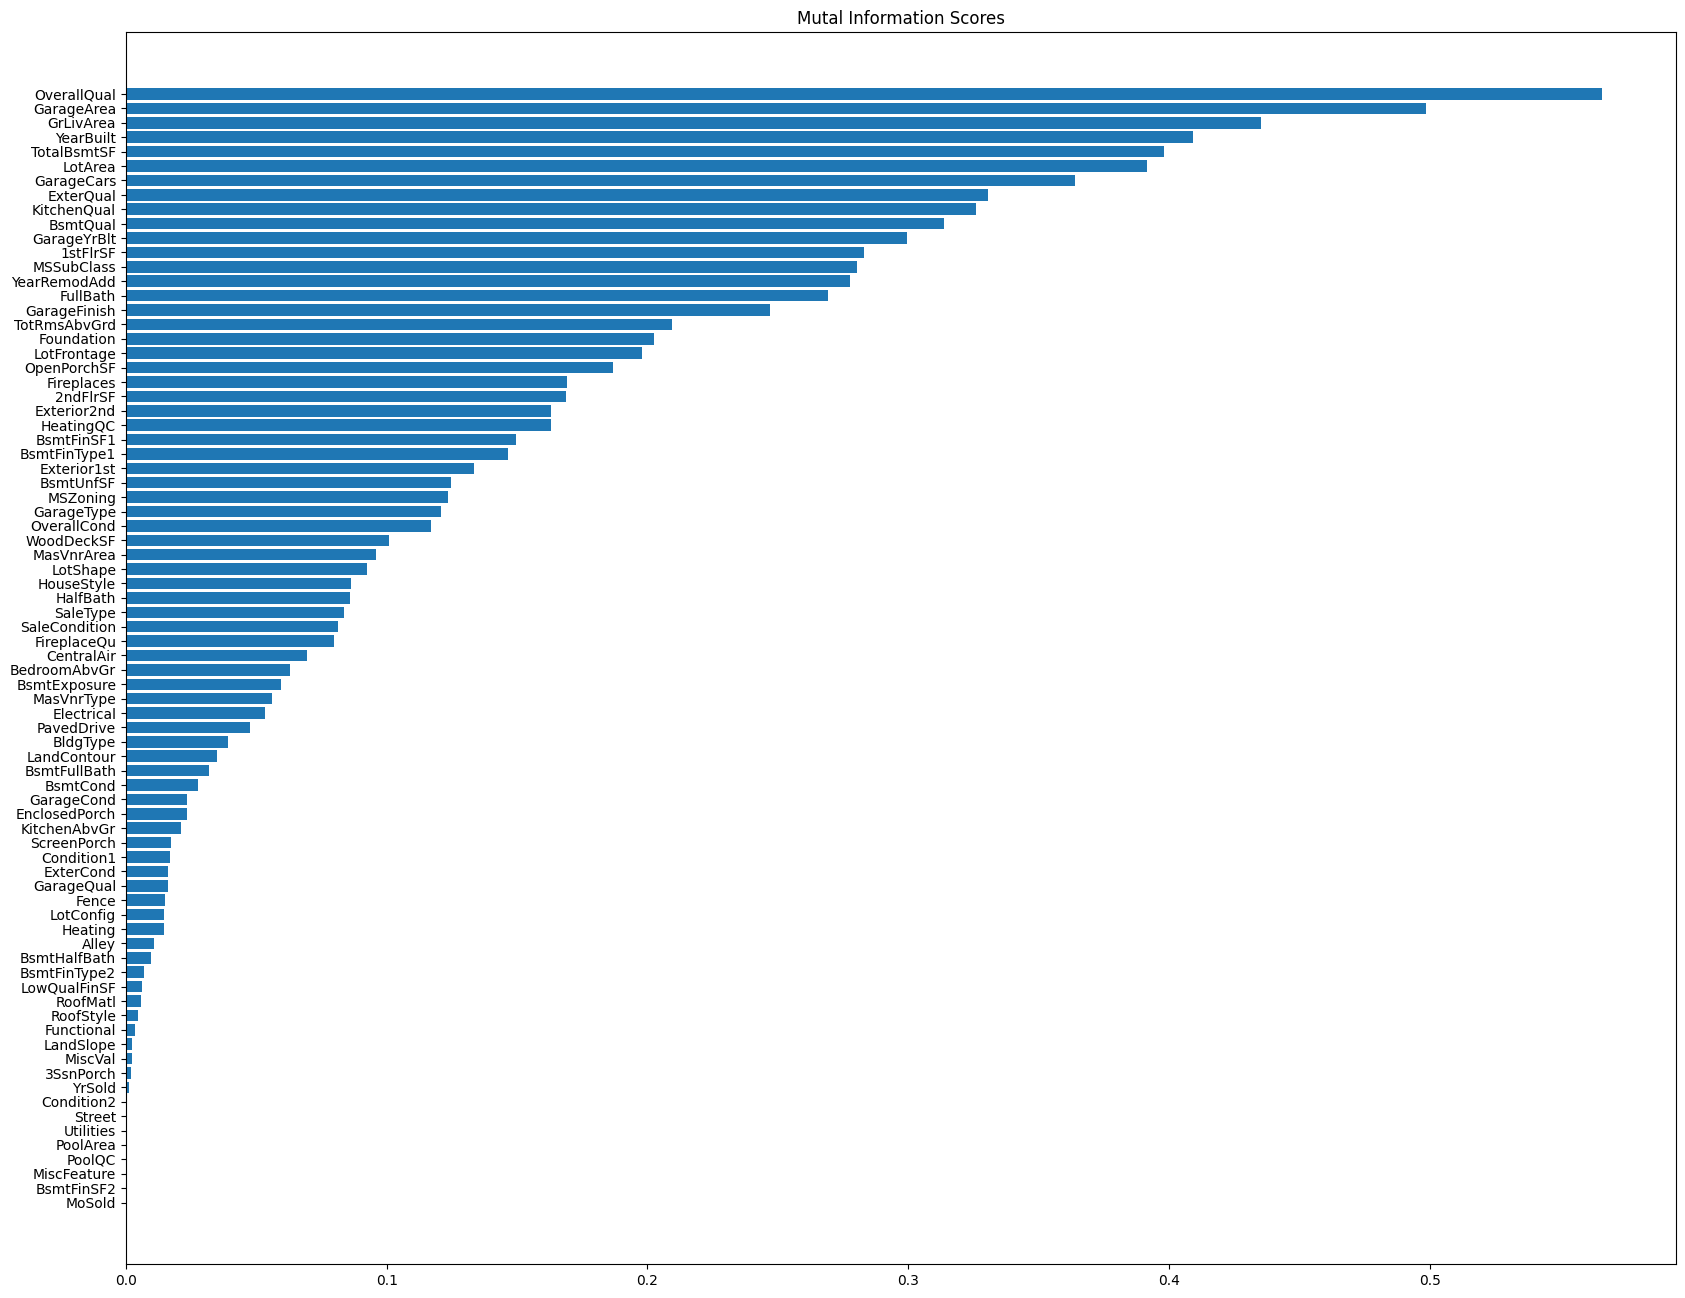

In [187]:
plt.figure(dpi=100, figsize=(20,16))
mi_plot(mi_scores)

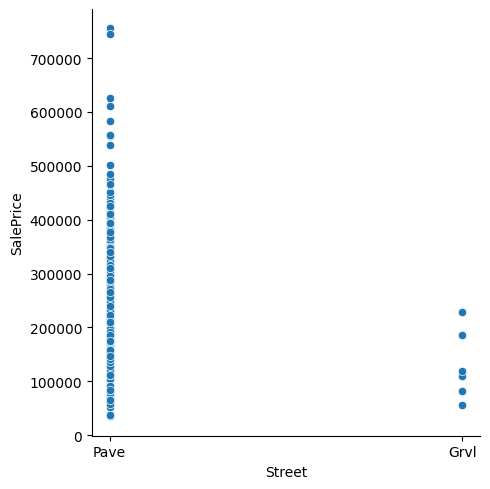

In [188]:
import seaborn as sns
sns.relplot(x="Street", y="SalePrice", data=train);

In [189]:
strong_features = [i for i in my_cols if i not in weak_features]
train_X = train_X[strong_features]

In [190]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
numerical = SimpleImputer(strategy='constant')
categorical = Pipeline(steps=[
    ('imp', SimpleImputer(strategy='most_frequent')),
    ('hot', OneHotEncoder(handle_unknown='ignore'))
])
preprocess = ColumnTransformer(transformers=[
    ('num', numerical, numerical_cols),
    ('cat', categorical, categorical_cols)
])

In [192]:
from xgboost import XGBRegressor
model = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', XGBRegressor(n_estimators=400 , learning_rate=0.3))
])
model.fit(train_X, train_Y)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers cont

In [193]:
pred = model.predict(test)

In [196]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, train_X, train_Y, cv = 5, scoring='r2')
print(f"Accuracy score: {scores}")

Accuracy score: [0.86123097 0.82960534 0.87361121 0.90140271 0.87096733]


In [197]:
scores.mean()

np.float64(0.8673635125160217)

In [198]:
from sklearn.ensemble import RandomForestRegressor
model2 = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', RandomForestRegressor(n_estimators=400, random_state=0))
])
model2.fit(train_X, train_Y)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers cont

In [199]:
pred2 = model2.predict(test)
scores2 = cross_val_score(model2, train_X, train_Y, cv = 5, scoring='r2')
print(f"Accuracy score: {scores2}")

Accuracy score: [0.87207947 0.83959678 0.87871902 0.88295378 0.84105724]


In [200]:
scores2.mean()

np.float64(0.8628812607799663)

In [203]:
my_cols

['MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'BsmtFinSF1',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'GrLivArea',
 'FullBath',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'MSZoning',
 'Exterior1st',
 'Exterior2nd',
 'ExterQual',
 'Foundation',
 'BsmtQual',
 'BsmtFinType1',
 'HeatingQC',
 'KitchenQual',
 'GarageType',
 'GarageFinish']